In [7]:
#!pip install git+https://github.com/PSLmodels/scf.git
#!pip install git+https://github.com/pslmodels/scf/
#!pip install quantile_forest

## Imputation of the Survey of Consumer Finances with Quantile Regression Forests

In [3]:
import microdf as mdf
import scf
import pandas as pd
from typing import Union
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

VALID_YEARS = [
    1989,
    1992,
    1995,
    1998,
    2001,
    2004,
    2007,
    2010,
    2013,
    2016,
    2019,
]

def scf_url(year: int) -> str:
    """ Returns the URL of the SCF summary microdata zip file for a year.

    :param year: Year of SCF summary microdata to retrieve.
    :type year: int
    :return: URL of summary microdata zip file for the given year.
    :rtype: str
    """
    assert year in VALID_YEARS, "The SCF is not available for " + str(year)
    return (
        "https://www.federalreserve.gov/econres/files/scfp"
        + str(year)
        + "s.zip"
    )


def load_single_scf(year: int, columns: list) -> pd.DataFrame:
    """ Loads SCF summary microdata for a given year and set of columns.

    :param year: Year of SCF summary microdata to retrieve.
    :type year: int
    :param columns: List of columns. The weight column `wgt` is always
        returned. Defaults to all columns in the summary dataset.
    :type columns: list
    :return: SCF summary microdata for the given year.
    :rtype: pd.DataFrame
    """
    # Add wgt to all returns.
    if columns is not None:
        columns = list(set(columns) | set(["wgt"]))
    return mdf.read_stata_zip(scf_url(year), columns=columns)


def load(
    years: list = VALID_YEARS,
    columns: list = None,
    as_microdataframe: bool = False,
) -> Union[pd.DataFrame, mdf.MicroDataFrame]:
    """ Loads SCF summary microdata for a set of years and columns.

    :param years: Year(s) to load SCF data for. Can be a list or single number.
        Defaults to all available years, starting with 1989.
    :type years: list
    :param columns: List of columns. The weight column `wgt` is always returned.
    :type columns: list
    :param as_microdataframe: Whether to return as a MicroDataFrame with
        weight set, defaults to False.
    :type as_microdataframe: bool
    :return: SCF summary microdata for the set of years.
    :rtype: Union[pd.DataFrame, mdf.MicroDataFrame]
    """
    # Make cols a list if a single column is passed.
    if columns is not None:
        columns = mdf.listify(columns)
    # If years is a single year rather than a list, don't use a loop.
    if isinstance(years, int):
        res = load_single_scf(years, columns)
    # Otherwise append to a list within a loop, and concatenate.
    else:
        scfs = []
        for year in years:
            tmp = load_single_scf(year, columns)
            tmp["year"] = year
            scfs.append(tmp)
        res = pd.concat(scfs)
    # Return as a MicroDataFrame or DataFrame.
    if as_microdataframe:
        return mdf.MicroDataFrame(res, weights="wgt")
    return res

## Data Load and Preprocessing

In [7]:
# focus on 2019 SCF data
data = load([VALID_YEARS[-1]])

# split data into train and test sets
train_df, test_df = train_test_split(data, test_size=0.2, train_size=0.8)

train_df.head()

,yy1,y1,wgt,hhsex,age,agecl,educ,edcl,married,kids,...,inccat,assetcat,ninccat,ninc2cat,nwpctlecat,incpctlecat,nincpctlecat,incqrtcat,nincqrtcat,year
14276,2873,28732,3670.294477,1,72,5,8,2,1,0,...,3,4,3,2,9,6,6,3,3,2019
2052,412,4123,4803.402127,1,23,1,9,3,2,0,...,2,1,3,1,1,3,5,1,2,2019
14538,2925,29254,5294.628615,2,55,4,12,4,2,0,...,6,6,6,3,9,11,11,4,4,2019
4808,967,9674,2781.647646,1,48,3,12,4,1,2,...,6,6,6,3,10,11,11,4,4,2019
18518,3727,37274,6838.369267,2,60,4,12,4,2,0,...,2,4,2,1,8,4,3,2,2,2019


In [11]:
for column in train_df.columns:
    print(column)
    break # remove to see all columns in dataset

yy1


In [82]:
# Load demographic predictor variables
dem_predictors = ["income", "age", "married", "kids", 
                     "educ", "race", "lf"]

train_df[dem_predictors].describe()

,income,age,married,kids,educ,race,lf
count,2.310800e+04,23108.000000,23108.000000,23108.000000,23108.000000,23108.000000,23108.000000
mean,1.164545e+06,53.231781,1.375022,0.747101,10.257313,1.545525,0.751947
std,1.290963e+07,16.236258,0.484139,1.123870,2.704084,1.055173,0.431892
min,0.000000e+00,18.000000,1.000000,0.000000,-1.000000,1.000000,0.000000
25%,4.248891e+04,40.000000,1.000000,0.000000,8.000000,1.000000,1.000000
50%,9.323955e+04,54.000000,1.000000,0.000000,11.000000,1.000000,1.000000
75%,2.310630e+05,65.000000,2.000000,1.000000,12.000000,2.000000,1.000000
max,8.156336e+08,95.000000,2.000000,7.000000,14.000000,5.000000,1.000000


In [72]:
# Load financial predictor variables
fin_predictors = ["houses", "equity", "trusts", "stocks", "asset", 
                     "saving", "wageinc", "kginc"]

train_df[fin_predictors].describe()

,houses,equity,trusts,stocks,asset,saving,wageinc,kginc
count,2.310800e+04,2.310800e+04,2.310800e+04,2.310800e+04,2.310800e+04,2.310800e+04,2.310800e+04,2.310800e+04
mean,8.518306e+05,3.601140e+06,6.088489e+05,1.402909e+06,1.604811e+07,5.971025e+04,1.660958e+05,4.319763e+05
std,3.118888e+06,2.912856e+07,1.028119e+07,1.192393e+07,9.237864e+07,5.269607e+05,1.008470e+06,1.250997e+07
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.030356e+06
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.904702e+04,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.109754e+05,1.112837e+04,0.000000e+00,0.000000e+00,4.265296e+05,1.159205e+01,4.720990e+04,0.000000e+00
75%,5.772842e+05,3.263743e+05,0.000000e+00,0.000000e+00,2.132619e+06,1.096898e+04,1.274667e+05,0.000000e+00
max,1.234322e+08,1.457828e+09,4.636821e+08,4.057219e+08,2.280388e+09,2.385645e+07,5.311114e+07,8.261732e+08


In [266]:
train_df["networth"].describe()

count    2.310800e+04
mean     1.568979e+07
std      9.125110e+07
min     -1.086257e+06
25%      2.506202e+04
50%      2.725871e+05
75%      1.877246e+06
max      2.280388e+09
Name: networth, dtype: float64

## Imputing Wealth

In [88]:
import sys
import os

# Get the parent directory of the current script
path = sys.path.append(os.path.abspath(os.path.join(os.path.dirname("SCF_imputation"), "..")))
from utils import QRF

In [202]:
# Choose the imputed variable for our analysis
imputed_variables = ["networth"]

y_train = train_df[imputed_variables]
y_test = test_df[imputed_variables]

In [252]:
# Quantile loss function from https://colab.research.google.com/drive/1E8F7S1Uvfw_3PmpS226Sl1LWV5NBi0CE#scrollTo=cMzFV5QU5RZr 

def quantile_loss(q, y, f):
    # q: Quantile to be evaluated, e.g., 0.5 for median.
    # y: True value.
    # f: Fitted or predicted value.
    e = y - f
    return np.maximum(q * e, (q - 1) * e)

In [315]:
# Run a Quantile Regression Forest on demographic predictors
dem_qrf = QRF()
dem_qrf.fit(train_df[dem_predictors], train_df[imputed_variables])

/Users/movil1/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [314]:
# Run a Quantile Regression Forest on financial predictors
fin_qrf = QRF()
fin_qrf.fit(train_df[fin_predictors], train_df[imputed_variables])

/Users/movil1/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


## Compare Results

In [137]:
QUANTILES = [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95]
quantiles_legend = [str(int(q * 100)) + 'th percentile' for q in QUANTILES]

In [326]:
# Compute quantile loss for demographic predictors in train and test sets
dem_train_losses = [np.mean(quantile_loss(q, y_train.values.flatten(),
                                          dem_qrf.predict(train_df[dem_predictors], mean_quantile=q).values.flatten()
                                         )) for q in QUANTILES]
dem_test_losses = [np.mean(quantile_loss(q, y_test.values.flatten(),
                                         dem_qrf.predict(test_df[dem_predictors], mean_quantile=q).values.flatten()
                                        )) for q in QUANTILES]

# Compute quantile loss for financial predictors in train and test sets
fin_train_losses = [np.mean(quantile_loss(q, y_train.values.flatten(),
                                          fin_qrf.predict(train_df[fin_predictors], mean_quantile=q).values.flatten()
                                         )) for q in QUANTILES]
fin_test_losses = [np.mean(quantile_loss(q, y_test.values.flatten(),
                                         fin_qrf.predict(test_df[fin_predictors], mean_quantile=q).values.flatten()
                                        )) for q in QUANTILES]

# Create dataframes for train and test losses
dem_loss_df = pd.DataFrame([dem_train_losses, dem_test_losses], columns=quantiles_legend, index=["Train", "Test"])
fin_loss_df = pd.DataFrame([fin_train_losses, fin_test_losses], columns=quantiles_legend, index=["Train", "Test"])

In [328]:
dem_loss_df

,5th percentile,10th percentile,30th percentile,50th percentile,70th percentile,90th percentile,95th percentile
Train,447979.763105,8.633777e+05,1.535028e+06,1.279662e+06,1.199471e+06,9.623650e+05,6.650492e+05
Test,662299.027279,1.314784e+06,1.995637e+06,2.937849e+06,2.563224e+06,1.727756e+06,1.145695e+06


In [330]:
fin_loss_df

,5th percentile,10th percentile,30th percentile,50th percentile,70th percentile,90th percentile,95th percentile
Train,51957.310908,85909.717252,146875.614765,85497.983420,79446.232105,57372.922858,38233.613523
Test,158320.309125,155736.486777,251410.791185,225780.082716,149974.872140,72964.420727,48999.022626


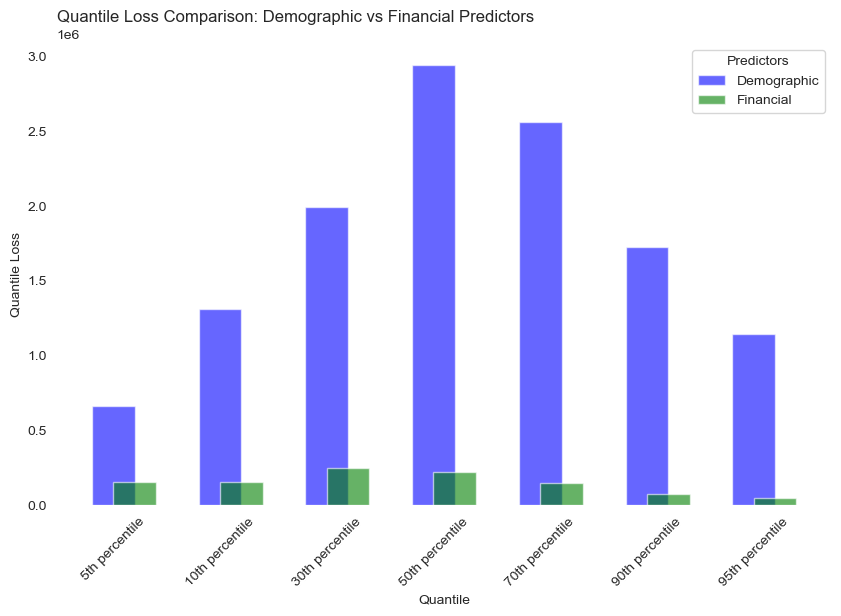

In [332]:
plt.figure(figsize=(10,6))
plt.bar(dem_loss_df.columns, dem_loss_df.loc["Test"], alpha=0.6, label="Demographic", width=0.4, align='center', color='blue')
plt.bar(fin_loss_df.columns, fin_loss_df.loc["Test"], alpha=0.6, label="Financial", width=0.4, align='edge', color='green')
plt.title("Quantile Loss Comparison: Demographic vs Financial Predictors", loc="left")
sns.despine(left=True, bottom=True)
plt.xlabel("Quantile")
plt.ylabel("Quantile Loss")
plt.legend(title="Predictors")
plt.xticks(rotation=45)
plt.show()

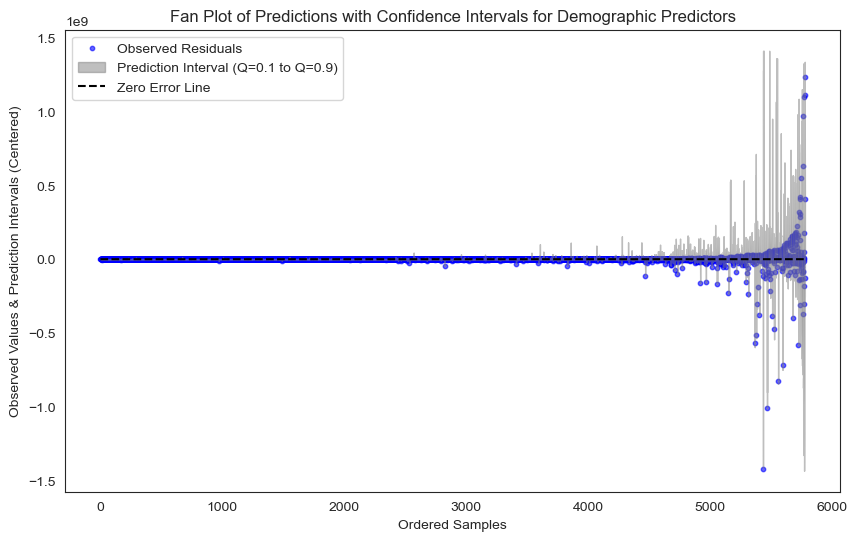

In [300]:
def plot_test_residuals(qrf, predictors, method, color):
    # Predict different quantiles
    q_10 = qrf.predict(test_df[predictors], mean_quantile=0.1)
    q_50 = qrf.predict(test_df[predictors], mean_quantile=0.5)
    q_90 = qrf.predict(test_df[predictors], mean_quantile=0.9)
    
    # Sort test samples for a smooth plot
    sorted_idx = np.argsort(y_test.values.flatten())
    y_sorted = y_test.iloc[sorted_idx].values.flatten()
    
    # Centered residuals (observed - predicted median)
    residuals = y_sorted - q_50.iloc[sorted_idx].values.flatten()
    
    # Compute lower and upper prediction intervals (also centered)
    lower_bound = q_10.iloc[sorted_idx].values.flatten() - q_50.iloc[sorted_idx].values.flatten()
    upper_bound = q_90.iloc[sorted_idx].values.flatten() - q_50.iloc[sorted_idx].values.flatten()
    
    # Create the fan plot
    plt.figure(figsize=(10,6))
    plt.scatter(range(len(y_sorted)), residuals, color=color, alpha=0.6, s=10, label="Observed Residuals")
    plt.fill_between(range(len(y_sorted)), lower_bound, upper_bound, color='gray', alpha=0.5, label="Prediction Interval (Q=0.1 to Q=0.9)")
    plt.plot(range(len(y_sorted)), np.zeros_like(y_sorted), 'k--', label="Zero Error Line")
    plt.xlabel("Ordered Samples")
    plt.ylabel("Observed Values & Prediction Intervals (Centered)")
    plt.title(f"Fan Plot of Predictions with Confidence Intervals for {method} Predictors")
    plt.legend()
    plt.show()

plot_test_residuals(dem_qrf, dem_predictors, "Demographic", "blue")

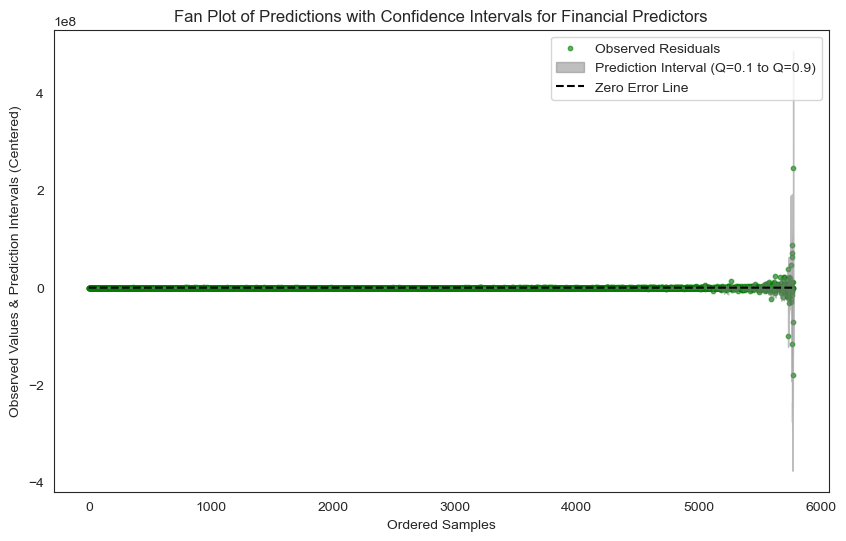

In [302]:
plot_test_residuals(fin_qrf, fin_predictors, "Financial", "green")

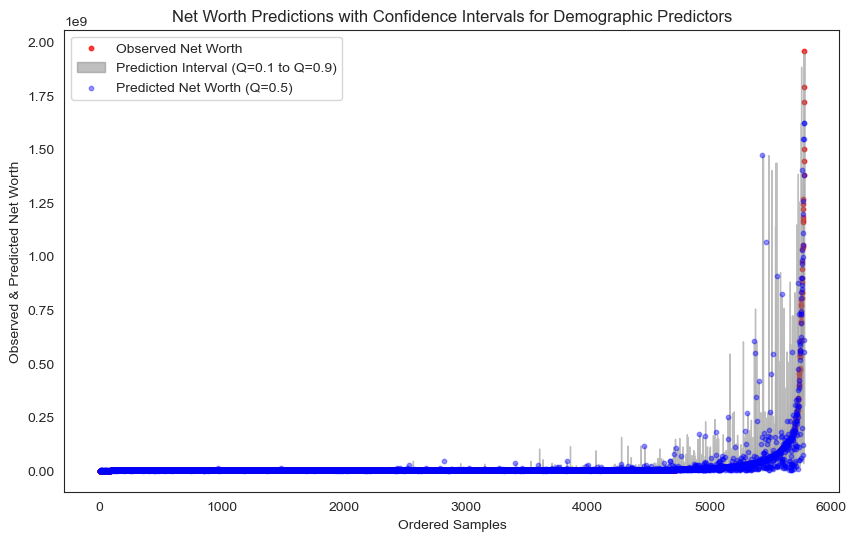

In [304]:
def plot_test_predictions(qrf, predictors, method, color):
    # Predict different quantiles
    q_10 = qrf.predict(test_df[predictors], mean_quantile=0.1)
    q_50 = qrf.predict(test_df[predictors], mean_quantile=0.5)
    q_90 = qrf.predict(test_df[predictors], mean_quantile=0.9)
    
    # Sort test samples for a smooth plot
    sorted_idx = np.argsort(y_test.values.flatten())
    y_sorted = y_test.iloc[sorted_idx].values.flatten()
    q_10_sorted = q_10.iloc[sorted_idx].values.flatten()
    q_50_sorted = q_50.iloc[sorted_idx].values.flatten()
    q_90_sorted = q_90.iloc[sorted_idx].values.flatten()
    
    # Plot the predicted Net Worth and its Confidence Intervals
    plt.figure(figsize=(10,6))
    plt.scatter(range(len(y_sorted)), y_sorted, color='red', alpha=0.75, s=10, label="Observed Net Worth")
    plt.fill_between(range(len(y_sorted)), q_10_sorted, q_90_sorted, color='gray', alpha=0.5, label="Prediction Interval (Q=0.1 to Q=0.9)")
    plt.scatter(range(len(y_sorted)), q_50_sorted, color=color, alpha=0.4, s=10, label="Predicted Net Worth (Q=0.5)")
    plt.xlabel("Ordered Samples")
    plt.ylabel("Observed & Predicted Net Worth")
    plt.title(f"Net Worth Predictions with Confidence Intervals for {method} Predictors")
    plt.legend()
    plt.show()

plot_test_predictions(dem_qrf, dem_predictors, "Demographic", "blue")

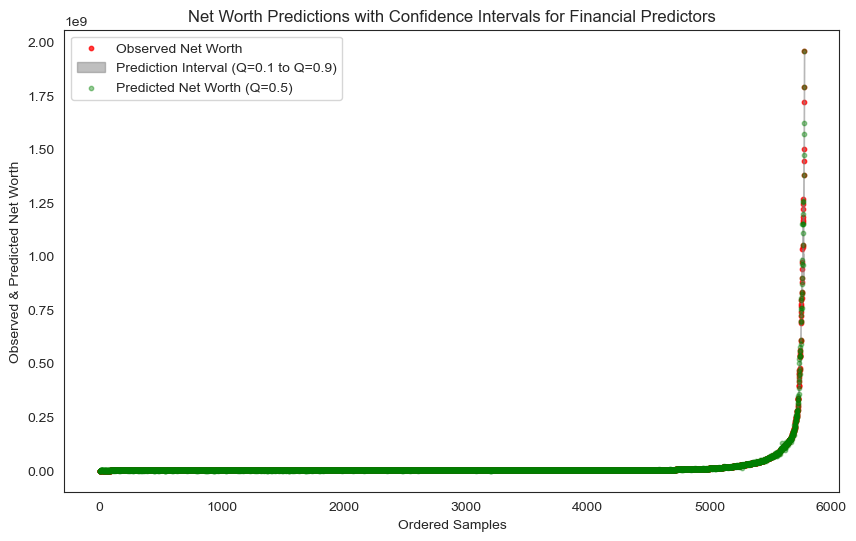

In [306]:
plot_test_predictions(fin_qrf, fin_predictors, "Financial", "green")